# Comparison of parameter inference results and enrichment analysis

Here, you will briefly learn how to use Storm to infer parameters and visualize the results compared to the dynamo twostep method, as well as perform enrichment analysis based on the results of parameter inference.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import dynamo as dyn
from dynamo.tools.dynamics import kinetic_model
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import seaborn as sns

## Load the data

The analysis is based on the cell cycle dataset. Here **rpe1_kinetics_without_spliced** contains only new and total RNA data, and **rpe1_kinetics** contains unspliced unlabeled (uu), unspliced labeled (ul), spliced unlabeled (su) and spliced labeled (sl) RNA data. 

To run analysis on your own data, read your file to an AnnData object with adata = dyn.read('file name'). 

In [2]:
filename = './data/rpe1.h5ad'
rpe1 = dyn.read(filename)

dyn.convert2float(rpe1, ['Cell_cycle_possition', 'Cell_cycle_relativePos'])

rpe1_kinetics = rpe1[rpe1.obs.exp_type == 'Pulse', :]
rpe1_kinetics.obs['time'] = rpe1_kinetics.obs['time'].astype(str)
rpe1_kinetics.obs.loc[rpe1_kinetics.obs['time'] == 'dmso', 'time'] = -1
rpe1_kinetics.obs['time'] = rpe1_kinetics.obs['time'].astype(float)
rpe1_kinetics = rpe1_kinetics[rpe1_kinetics.obs.time != -1, :]

rpe1_kinetics.obs.time = rpe1_kinetics.obs.time.astype('float')
rpe1_kinetics.obs.time = rpe1_kinetics.obs.time / 60  # convert minutes to hours

rpe1_kinetics_without_spliced = rpe1_kinetics.copy()

rpe1_kinetics_without_spliced.layers['new'], rpe1_kinetics_without_spliced.layers['total'] = rpe1_kinetics_without_spliced.layers['ul'] + rpe1_kinetics_without_spliced.layers['sl'], \
                                                             rpe1_kinetics_without_spliced.layers['su'] + rpe1_kinetics_without_spliced.layers['sl'] + \
                                                             rpe1_kinetics_without_spliced.layers['uu'] + rpe1_kinetics_without_spliced.layers['ul']

del rpe1_kinetics_without_spliced.layers['uu'], rpe1_kinetics_without_spliced.layers['ul'], rpe1_kinetics_without_spliced.layers['su'], rpe1_kinetics_without_spliced.layers['sl']

del rpe1

##  CSP, CSZIP and Dynamo twostep methods parameter inference results based on data without spliced mRNA information

### Preprocess the data

Preprocessing includes steps such as selecting highly variable genes and normalizing each cell by the total size. Since the parameter inference methods of CSP and CSZIP require raw counts, you need to set **keep_raw_layers=True**.

In [3]:
dyn.preprocessing.recipe_monocle(
    rpe1_kinetics_without_spliced,
    tkey='time',
    experiment_type="kin",
    reset_X=True,
    X_total_layers=False,
    splicing_total_layers=False,
    n_top_genes=1000,
    total_layers=True,
    keep_filtered_cells=False,
    keep_filtered_genes=False,
    keep_raw_layers=True,
)

|-----> apply Monocole recipe to adata...
|-----> convert ensemble name to official gene name
|-----? Your adata object uses non-official gene names as gene index. 
Dynamo is converting those names to official gene names.
|-----> Storing myGene name info into local cache db: mygene_cache.sqlite.
[ Future queries will be cached in "/home/pqw/pythonProject3/mygene_cache.sqlite" ]
querying 1-1000...done. [ from cache ]
querying 1001-2000...done. [ from cache ]
querying 2001-3000...done. [ from cache ]
querying 3001-4000...done. [ from cache ]
querying 4001-5000...done. [ from cache ]
querying 5001-6000...done. [ from cache ]
querying 6001-7000...done. [ from cache ]
querying 7001-8000...done. [ from cache ]
querying 8001-9000...done. [ from cache ]
querying 9001-10000...done. [ from cache ]
querying 10001-11000...done. [ from cache ]
querying 11001-11848...done. [ from cache ]
Finished.
1 input query terms found dup hits:
	[('ENSG00000229425', 2)]
35 input query terms found no hit:
	['ENS

Further, we need the first order moments computed among nearest neighbors in PCA space.

In [4]:
dyn.tl.moments(rpe1_kinetics_without_spliced, group='time')
sub_adata_without_spliced = rpe1_kinetics_without_spliced[:,rpe1_kinetics_without_spliced.var['use_for_pca']]

del rpe1_kinetics_without_spliced

|-----> calculating first/second moments...
|-----> [moments calculation] in progress: 100.0000%
|-----> [moments calculation] finished [13.8165s]


### Parameter Inference

Use the **kinetic_model** function in the dynamo package for parameter inference. 

Set **est_method="twostep"** to run the dynamo twostep method:

In [5]:
# Dynamo twostep method
results_dynamo = kinetic_model(
    sub_adata_without_spliced,
    est_method="twostep",
    tkey="time",
    model="deterministic",
    experiment_type="kin",
    has_splicing=False,
    splicing_labeling=False,
    has_switch=False,
    data_type="smoothed",
    return_ntr=False,
    param_rngs={},
)
Dynamo_params = results_dynamo[0]
Dynamo_gamma = Dynamo_params['gamma']
Dynamo_gamma_r2 = Dynamo_params['gamma_r2']

|-----> experiment type: kin, method: twostep, model: deterministic


Estimate gamma via linear regression of t vs. -ln(1-K): 1000it [00:01, 610.65it/s]


Set **est_method="CSP4ML_CSP"** to run the CSP method:

In [6]:
# CSP method
results_csp = kinetic_model(
    sub_adata_without_spliced,
    est_method="CSP4ML_CSP",
    tkey="time",
    model="deterministic",
    experiment_type="kin",
    has_splicing=False,
    splicing_labeling=False,
    has_switch=False,
    data_type="smoothed",
    return_ntr=False,
    param_rngs={},
)
CSP_params = results_csp[0]
CSP_gamma = CSP_params['gamma']
CSP_cell_wise_alpha = CSP_params['alpha'].A
CSP_alpha = np.mean(CSP_cell_wise_alpha,axis=1)
CSP_gamma_r2 = CSP_params['gamma_r2_raw']

|-----> experiment type: kin, method: CSP4ML_CSP, model: deterministic


Estimate gamma via linear regression of t vs. -ln(1-K): 1000it [00:01, 620.77it/s]
Infer parameters via maximum likelihood estimation based on the CSP model: 90it [00:00, 445.01it/s]

Inequality constraints incompatible


Infer parameters via maximum likelihood estimation based on the CSP model: 673it [00:01, 482.33it/s]

Inequality constraints incompatible


Infer parameters via maximum likelihood estimation based on the CSP model: 837it [00:01, 518.64it/s]

Inequality constraints incompatible


Infer parameters via maximum likelihood estimation based on the CSP model: 1000it [00:02, 486.14it/s]


Set **est_method="CSP4ML_CSZIP"** to run the CSZIP method.

In [7]:
# CSZIP method
results_cszip = kinetic_model(
    sub_adata_without_spliced,
    est_method="CSP4ML_CSZIP",
    tkey="time",
    model="deterministic",
    experiment_type="kin",
    has_splicing=False,
    splicing_labeling=False,
    has_switch=False,
    data_type="smoothed",
    return_ntr=False,
    param_rngs={},
)
CSZIP_params = results_cszip[0]
CSZIP_gamma = CSZIP_params['gamma']
CSZIP_prob_off = CSZIP_params['prob_off']
CSZIP_gamma_r2 = CSZIP_params['gamma_r2_raw']

|-----> experiment type: kin, method: CSP4ML_CSZIP, model: deterministic


Estimate gamma via linear regression of t vs. -ln(1-K): 1000it [00:01, 617.37it/s]
Infer parameters via maximum likelihood estimation based on the CSZIP model: 33it [00:00, 137.59it/s]

Inequality constraints incompatible
Inequality constraints incompatible


Infer parameters via maximum likelihood estimation based on the CSZIP model: 353it [00:02, 145.52it/s]

Inequality constraints incompatible


Infer parameters via maximum likelihood estimation based on the CSZIP model: 615it [00:04, 146.44it/s]

Inequality constraints incompatible


Infer parameters via maximum likelihood estimation based on the CSZIP model: 754it [00:05, 143.20it/s]

Inequality constraints incompatible


Infer parameters via maximum likelihood estimation based on the CSZIP model: 817it [00:05, 149.45it/s]

Inequality constraints incompatible
Inequality constraints incompatible


Infer parameters via maximum likelihood estimation based on the CSZIP model: 847it [00:06, 132.80it/s]

Inequality constraints incompatible


Infer parameters via maximum likelihood estimation based on the CSZIP model: 1000it [00:07, 136.86it/s]


##  ICSP and Dynamo twostep methods parameter inference results based on data with spliced mRNA information

### Preprocess the data

In [8]:
dyn.preprocessing.recipe_monocle(
    rpe1_kinetics,
    tkey='time',
    experiment_type="kin",
    reset_X=True,
    X_total_layers=False,
    splicing_total_layers=False,
    n_top_genes=1000,
    total_layers=True,
    keep_filtered_cells=False,
    keep_filtered_genes=False,
    keep_raw_layers=True,
)
layers = ["X_new", "X_total", "X_uu", "X_ul", "X_su", "X_sl"] + ["new", "total", "uu", "ul", "su", "sl"]
dyn.tl.moments(rpe1_kinetics, group='time', layers=layers)

# then we want to calculate moments for spliced and unspliced layers based on connectivity graph from spliced
# data.
# first get X_spliced based pca embedding
CM = np.log1p(rpe1_kinetics[:, rpe1_kinetics.var.use_for_pca].layers["X_spliced"].A)
cm_genesums = CM.sum(axis=0)
valid_ind = np.logical_and(np.isfinite(cm_genesums), cm_genesums != 0)
valid_ind = np.array(valid_ind).flatten()

dyn.preprocessing.utils.pca(rpe1_kinetics, CM[:, valid_ind], pca_key="X_spliced_pca")
# then get neighbors graph based on X_spliced_pca
dyn.tl.connectivity.neighbors(rpe1_kinetics, X_data=rpe1_kinetics.obsm["X_spliced_pca"], layer="X_spliced")
# then normalize neighbors graph so that each row sums up to be 1
conn = dyn.tl.connectivity.normalize_knn_graph(rpe1_kinetics.obsp["connectivities"] > 0)
# then calculate moments for spliced related layers using spliced based connectivity graph
dyn.tl.moments(rpe1_kinetics, conn=conn, layers=["X_spliced", "X_unspliced"])
# then perform kinetic estimations with properly preprocessed layers for either the labeling or the splicing
# data

sub_adata = rpe1_kinetics[:,rpe1_kinetics.var['use_for_pca']]
del rpe1_kinetics

|-----> apply Monocole recipe to adata...
|-----> convert ensemble name to official gene name
|-----? Your adata object uses non-official gene names as gene index. 
Dynamo is converting those names to official gene names.
|-----> Storing myGene name info into local cache db: mygene_cache.sqlite.
[ Future queries will be cached in "/home/pqw/pythonProject3/mygene_cache.sqlite" ]
querying 1-1000...done. [ from cache ]
querying 1001-2000...done. [ from cache ]
querying 2001-3000...done. [ from cache ]
querying 3001-4000...done. [ from cache ]
querying 4001-5000...done. [ from cache ]
querying 5001-6000...done. [ from cache ]
querying 6001-7000...done. [ from cache ]
querying 7001-8000...done. [ from cache ]
querying 8001-9000...done. [ from cache ]
querying 9001-10000...done. [ from cache ]
querying 10001-11000...done. [ from cache ]
querying 11001-11848...done. [ from cache ]
Finished.
1 input query terms found dup hits:
	[('ENSG00000229425', 2)]
35 input query terms found no hit:
	['ENS

### Parameter Inference

Due to the use of spliced RNA data, it is necessary to set **has_splicing=True**.

Set **est_method="twostep"** to run the dynamo twostep method:

In [9]:
# Dynamo twostep method
results_dynamo = kinetic_model(
    sub_adata,
    est_method="twostep",
    tkey="time",
    model="deterministic",
    experiment_type="kin",
    has_splicing=True,
    splicing_labeling=True,
    has_switch=False,
    data_type="smoothed",
    return_ntr=False,
    param_rngs={},
)
params = results_dynamo[0]
Dynamo_beta = params['beta']

|-----> experiment type: kin, method: twostep, model: deterministic


Estimate slope k via linear regression.: 1000it [00:01, 717.77it/s]
Estimate gamma via linear regression of t vs. -ln(1-K): 1000it [00:01, 616.88it/s]


Set **est_method="CSP4ML_ICSP"** to run the ICSP method:

In [10]:
# ICSP method
results_icsp = kinetic_model(
    sub_adata,
    est_method="CSP4ML_ICSP",
    tkey="time",
    model="deterministic",
    experiment_type="kin",
    has_splicing=True,
    splicing_labeling=True,
    has_switch=False,
    data_type="smoothed",
    return_ntr=False,
    param_rngs={},
)
params = results_icsp[0]
ICSP_cell_wise_beta = params['beta'].A
ICSP_beta = np.mean(ICSP_cell_wise_beta,axis=1)
ICSP_gamma_s = params['gamma'] # gamma_s
ICSP_gamma = params['gamma_t'] # gamma_t
ICSP_gamma_r2 = params['gamma_r2_raw']

|-----> experiment type: kin, method: CSP4ML_ICSP, model: deterministic


Estimate slope k via linear regression.: 1000it [00:01, 719.06it/s]
Estimate gamma via linear regression of t vs. -ln(1-K): 1000it [00:01, 614.17it/s]
Estimate gamma via maximum likelihood estimation based on the ICSP model : 1000it [00:04, 206.30it/s]
Estimate cell specific alpha and beta: 1000it [08:11,  2.03it/s]


## Plot the comparison of parameter inference results

The twostep, CSP and CSZIP methods described above can infer the parameters ($\alpha$ and $\gamma_t$) when no splicing information is included, and twostep and ICSP can infer the parameters ($\alpha$, $\gamma_s$, $\beta$ and $\gamma_t$ ) when splicing information is included. We compare the parameters inferred by the different methods.

Set the goodness-of-fit to 0 for nan value:

In [11]:
CSP_gamma_r2[np.isnan(CSP_gamma_r2)] = 0
CSZIP_gamma_r2[np.isnan(CSZIP_gamma_r2)] = 0
ICSP_gamma_r2[np.isnan(ICSP_gamma_r2)] = 0
Dynamo_gamma_r2[np.isnan(Dynamo_gamma_r2)] = 0

Select genes that fit well with different methods (well fitting is defined as the top 400 genes with the highest goodness of fit):

In [12]:
overlap_number = 400 # the number of well-fitted genes selected by each method

# ranking the goodness of fit of different methods
index_CSP = np.argsort(-CSP_gamma_r2)
index_CSZIP = np.argsort(-CSZIP_gamma_r2)
index_ICSP = np.argsort(-ICSP_gamma_r2)
index_Dynamo = np.argsort(-Dynamo_gamma_r2)

# obtaining indicators of overlapping genes that fit well by different methods
index_CSP_CSZIP = np.intersect1d(index_CSP[range(overlap_number)], index_CSZIP[range(overlap_number)])
index_CSP_ICSP = np.intersect1d(index_CSP[range(overlap_number)], index_ICSP[range(overlap_number)])
index_CSP_Dynamo = np.intersect1d(index_CSP[range(overlap_number)], index_Dynamo[range(overlap_number)])
index_ICSP_Dynamo = np.intersect1d(index_ICSP[range(overlap_number)], index_Dynamo[range(overlap_number)])
index_ICSP_ICSP = np.intersect1d(index_ICSP[range(overlap_number)], index_ICSP[range(overlap_number)])

### Scatter plot of comparison results

Change the matplotlib settings for better visualization:

In [13]:
sc.set_figure_params(scanpy=True, fontsize=6)
scatter_size = 10
figsize = (1.61, 1.61)
alpha = 0.3
dpi = 150

Comparison of the $\gamma_t$ of CSP and CSZIP:

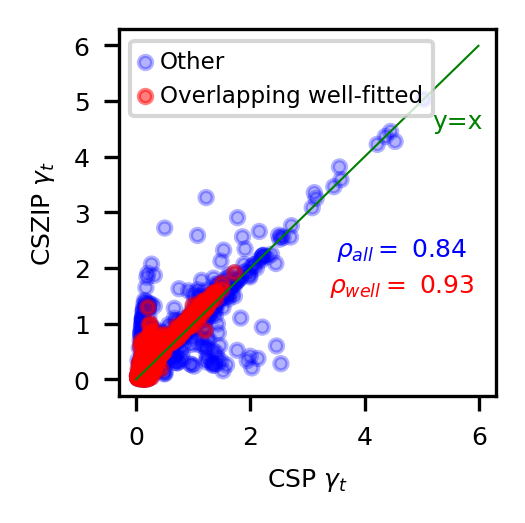

In [14]:
# for y=x green line
range_min = 0
range_max = 6
x = np.arange(range_min, range_max, 0.01)
y = x

# comparison of the gamma_t of CSP and CSZIP
index_no_nan = np.logical_and(np.isfinite(CSZIP_gamma), np.isfinite(CSZIP_gamma))
# correlation coefficient between all the genes
rho_all = np.corrcoef(CSP_gamma[index_no_nan], CSZIP_gamma[index_no_nan])
# correlation coefficient between well_fitted genes
rho_well_fitted = np.corrcoef(CSP_gamma[index_CSP_CSZIP], CSZIP_gamma[index_CSP_CSZIP])

fig = plt.figure(1, figsize=figsize, dpi=dpi)
ax = fig.add_subplot(111)
ax.scatter(CSP_gamma, CSZIP_gamma, color='blue', s=scatter_size * np.ones_like(CSP_gamma), alpha=alpha,
           label='Other')
ax.scatter(CSP_gamma[index_CSP_CSZIP], CSZIP_gamma[index_CSP_CSZIP], color='red',
           s=scatter_size * np.ones_like(index_CSP_CSZIP), alpha=0.5, label='Overlapping well-fitted')
plt.legend()
ax.plot(x, y, color='g', linewidth=0.5, label='y=x')
plt.text(0.9, 0.75, 'y=x', ha='center', va='center', transform=ax.transAxes, color='g')
plt.text(0.75, 0.4, '$\\rho_{all}=$ %4.2f' % rho_all[0][1], 
         ha='center', va='center', transform=ax.transAxes, color='b')
plt.text(0.75, 0.3, '$\\rho_{well}=$ %4.2f' % rho_well_fitted[0][1], 
         ha='center', va='center', transform=ax.transAxes, color='r')
plt.xlabel('CSP $\gamma_{t}$')
plt.ylabel('CSZIP $\gamma_{t}$')
plt.grid(False)
plt.show()
# plt.savefig('./Figures/dataset1/parameter_comp/comp_figures/1.pdf', dpi=dpi, bbox_inches="tight")

The results show that the $\gamma_t$ inferred by the CSP and CSZIP models are close, especially in the genes that are well fitted by both methods.

Comparison of the $\gamma_t$ of CSP and ICSP:

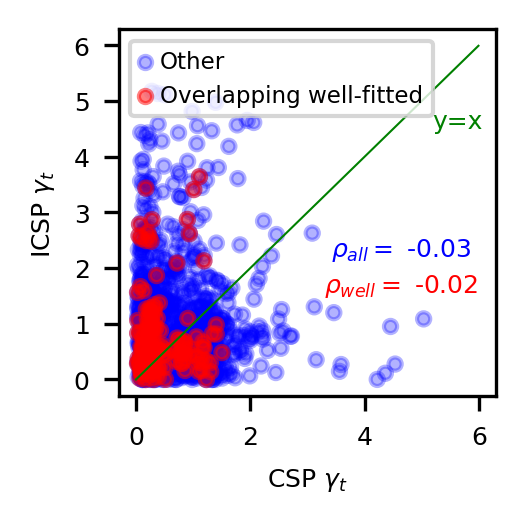

In [15]:
index_no_nan = np.logical_and(np.isfinite(CSP_gamma), np.isfinite(ICSP_gamma))
rho_all = np.corrcoef(CSP_gamma[index_no_nan], ICSP_gamma[index_no_nan])
rho_well_fitted = np.corrcoef(CSP_gamma[index_CSP_ICSP], ICSP_gamma[index_CSP_ICSP])

fig = plt.figure(2, figsize=figsize, dpi=dpi)
ax = fig.add_subplot(111)
ax.scatter(CSP_gamma, ICSP_gamma, color='blue', s=scatter_size * np.ones_like(CSP_gamma), alpha=alpha,
           label='Other')
ax.scatter(CSP_gamma[index_CSP_ICSP], ICSP_gamma[index_CSP_ICSP], color='red',
           s=scatter_size * np.ones_like(index_CSP_ICSP), alpha=0.5, label='Overlapping well-fitted')
plt.legend()
ax.plot(x, y, color='g', linewidth=0.5, label='y=x')
plt.text(0.9, 0.75, 'y=x', ha='center', va='center', transform=ax.transAxes, color='g')
plt.text(0.75, 0.4, '$\\rho_{all}=$ %4.2f' % rho_all[0][1], 
         ha='center', va='center', transform=ax.transAxes, color='b')
plt.text(0.75, 0.3, '$\\rho_{well}=$ %4.2f' % rho_well_fitted[0][1], 
         ha='center', va='center', transform=ax.transAxes, color='r')
plt.xlabel('CSP $\gamma_{t}$')
plt.ylabel('ICSP $\gamma_{t}$')
plt.grid(False)
plt.show()
# plt.savefig('./Figures/dataset1/parameter_comp/comp_figures/2.pdf', dpi=150, bbox_inches="tight")

The results show a large difference in $\gamma_t$ inferred by the CSP and ICSP models, and we believe the possible reason is that the assumptions made by the two models are fundamentally different.

Comparison of $\gamma_t$ and $\gamma_s$ of ICSP:

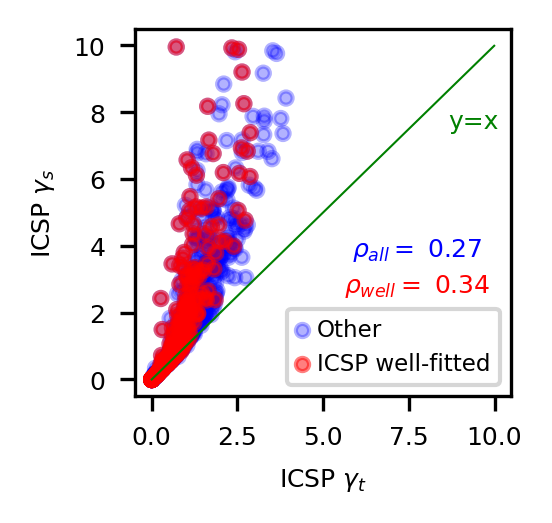

In [16]:
index_no_nan = np.logical_and(np.isfinite(ICSP_gamma), np.isfinite(ICSP_gamma_s))
rho_all = np.corrcoef(ICSP_gamma[index_no_nan], ICSP_gamma_s[index_no_nan])
rho_well_fitted = np.corrcoef(ICSP_gamma[index_ICSP_ICSP], ICSP_gamma_s[index_ICSP_ICSP])

# only genes with gamma_s less than 10 are shown for better visualization
index_ICSP_leq10 = np.where(ICSP_gamma_s < 10)
index_ICSP_ICSP_leq10 = np.intersect1d(index_ICSP_ICSP, index_ICSP_leq10)
x_ICSP = np.arange(0, 10, 0.01)
y_ICSP = x_ICSP

fig = plt.figure(3, figsize=figsize, dpi=dpi)
ax = fig.add_subplot(111)
ax.scatter(ICSP_gamma[index_ICSP_leq10], ICSP_gamma_s[index_ICSP_leq10], color='blue',
           s=scatter_size * np.ones_like(index_ICSP_leq10), alpha=alpha,
           label='Other')
ax.scatter(ICSP_gamma[index_ICSP_ICSP_leq10], ICSP_gamma_s[index_ICSP_ICSP_leq10], color='red',
           s=scatter_size * np.ones_like(index_ICSP_ICSP_leq10), alpha=0.5, label='ICSP well-fitted')
plt.legend(loc='lower right')
ax.plot(x_ICSP, y_ICSP, color='g', linewidth=0.5, label='y=x')
plt.text(0.9, 0.75, 'y=x', ha='center', va='center', transform=ax.transAxes, color='g')
plt.text(0.75, 0.4, '$\\rho_{all}=$ %4.2f' % rho_all[0][1], 
         ha='center', va='center', transform=ax.transAxes, color='b')
plt.text(0.75, 0.3, '$\\rho_{well}=$ %4.2f' % rho_well_fitted[0][1], 
         ha='center', va='center', transform=ax.transAxes, color='r')
plt.xlabel('ICSP $\gamma_{t}$')
plt.ylabel('ICSP $\gamma_{s}$')
plt.grid(False)
plt.show()
# plt.savefig('./Figures/dataset1/parameter_comp/comp_figures/3.pdf', dpi=150, bbox_inches="tight")

The results show that the calculated $\gamma_s$ are usually larger than $\gamma_t$, which is consistent with the theory.

Comparison of the $\gamma_t$ of CSP and Dynamo twostep:

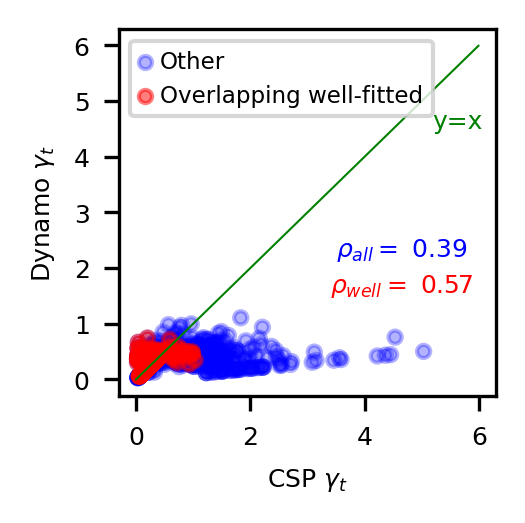

In [17]:
index_no_nan = np.logical_and(np.isfinite(CSP_gamma), np.isfinite(Dynamo_gamma))
rho_all = np.corrcoef(CSP_gamma[index_no_nan], Dynamo_gamma[index_no_nan])
rho_well_fitted = np.corrcoef(CSP_gamma[index_CSP_Dynamo], Dynamo_gamma[index_CSP_Dynamo])

fig = plt.figure(4, figsize=figsize, dpi=dpi)
ax = fig.add_subplot(111)
ax.scatter(CSP_gamma, Dynamo_gamma, color='blue', s=scatter_size * np.ones_like(CSP_gamma), alpha=alpha,
           label='Other')
ax.scatter(CSP_gamma[index_CSP_Dynamo], Dynamo_gamma[index_CSP_Dynamo], color='red',
           s=scatter_size * np.ones_like(index_CSP_Dynamo), alpha=0.5, label='Overlapping well-fitted')
plt.legend()
ax.plot(x, y, color='g', linewidth=0.5, label='y=x')
plt.text(0.9, 0.75, 'y=x', ha='center', va='center', transform=ax.transAxes, color='g')
plt.text(0.75, 0.4, '$\\rho_{all}=$ %4.2f' % rho_all[0][1], 
         ha='center', va='center', transform=ax.transAxes, color='b')
plt.text(0.75, 0.3, '$\\rho_{well}=$ %4.2f' % rho_well_fitted[0][1], 
         ha='center', va='center', transform=ax.transAxes, color='r')
plt.xlabel('CSP $\gamma_{t}$')
plt.ylabel('Dynamo $\gamma_{t}$')
plt.grid(False)
plt.show()
# plt.savefig('./Figures/dataset1/parameter_comp/comp_figures/4.pdf', dpi=150, bbox_inches="tight")

The results show that the parameters of the CSP and Dynamo twostep methods are close in genes that are well fitted by both, and there are large differences in other genes.

Comparison of the $\beta$ of ICSP and Dynamo twostep

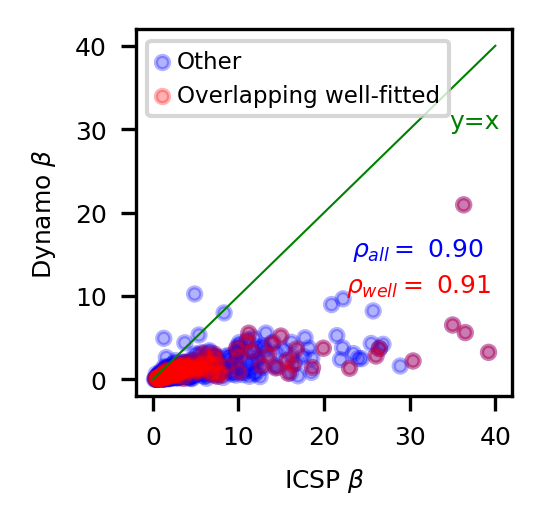

In [18]:
index_no_nan = np.logical_and(np.isfinite(ICSP_beta), np.isfinite(Dynamo_beta))
rho_all = np.corrcoef(ICSP_beta[index_no_nan], Dynamo_beta[index_no_nan])
rho_well_fitted = np.corrcoef(ICSP_beta[index_ICSP_Dynamo], Dynamo_beta[index_ICSP_Dynamo])

# only genes with beta less than 40 are shown for better visualization
index_ICSP_Dynamo_beta_leq40 = np.where(np.logical_and(ICSP_beta < 40, Dynamo_beta < 40)) 
index_ICSP_Dynamo_fitwell_beta_leq40 = np.intersect1d(index_ICSP_Dynamo, index_ICSP_Dynamo_beta_leq40)
x_ICSP_Dynamo_beta = np.arange(0, 40, 0.01)
y_ICSP_Dynamo_beta = x_ICSP_Dynamo_beta

fig = plt.figure(5, figsize=figsize, dpi=dpi)
ax = fig.add_subplot(111)
ax.scatter(ICSP_beta[index_ICSP_Dynamo_beta_leq40], Dynamo_beta[index_ICSP_Dynamo_beta_leq40], color='blue',
           s=scatter_size * np.ones_like(index_ICSP_Dynamo_beta_leq40), alpha=alpha,
           label='Other')
ax.scatter(ICSP_beta[index_ICSP_Dynamo_fitwell_beta_leq40], Dynamo_beta[index_ICSP_Dynamo_fitwell_beta_leq40],
           color='red',
           s=scatter_size * np.ones_like(index_ICSP_Dynamo_fitwell_beta_leq40), alpha=alpha,
           label='Overlapping well-fitted')
plt.legend()
ax.plot(x_ICSP_Dynamo_beta, y_ICSP_Dynamo_beta, color='g', linewidth=0.5, label='y=x')
plt.text(0.9, 0.75, 'y=x', ha='center', va='center', transform=ax.transAxes, color='g')
plt.text(0.75, 0.4, '$\\rho_{all}=$ %4.2f' % rho_all[0][1], 
         ha='center', va='center', transform=ax.transAxes, color='b')
plt.text(0.75, 0.3, '$\\rho_{well}=$ %4.2f' % rho_well_fitted[0][1], 
         ha='center', va='center', transform=ax.transAxes, color='r')
plt.xlabel('ICSP $\\beta$')
plt.ylabel('Dynamo $\\beta$')
plt.grid(False)
plt.show()
# plt.savefig('./Figures/dataset1/parameter_comp/comp_figures/5.pdf', dpi=150, bbox_inches="tight")

The results show that the $\beta$ calculated by the ICSP method is usually larger than that calculated by the Dynamo twostep method. We think the possible reason is that the Dynamo twostep method confused $\gamma_t$ and $\gamma_s$, which leads to the wrong $\beta$.

In [19]:
figsize_new = (1.32, 2.2 * 0.857)
index_CSP_r2_over_n1 = np.where(CSP_gamma_r2 > -1)
index_CSZIP_r2_over_n1 = np.where(CSZIP_gamma_r2 > -1)
index_ICSP_r2_over_n1 = np.where(ICSP_gamma_r2 > -1)

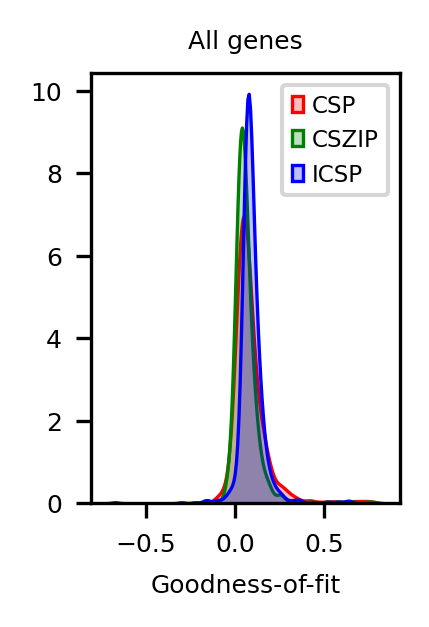

In [20]:
fig = plt.figure(6, figsize=figsize_new, dpi=dpi)
ax = fig.add_subplot(111)
sns.kdeplot(CSP_gamma_r2[index_CSP_r2_over_n1], shade=True, ax=ax, color='red', label='CSP', linewidth=0.8)
sns.kdeplot(CSZIP_gamma_r2[index_CSZIP_r2_over_n1], shade=True, ax=ax, color='g', label='CSZIP', linewidth=0.8)
sns.kdeplot(ICSP_gamma_r2[index_ICSP_r2_over_n1], shade=True, ax=ax, color='b', label='ICSP', linewidth=0.8)
plt.grid(False)
plt.title('All genes')
plt.xlabel('Goodness-of-fit')
plt.ylabel('')
plt.legend()
# plt.savefig('./figures/figure2/Comp/gof_all.pdf', dpi=dpi, bbox_inches="tight")
plt.show()

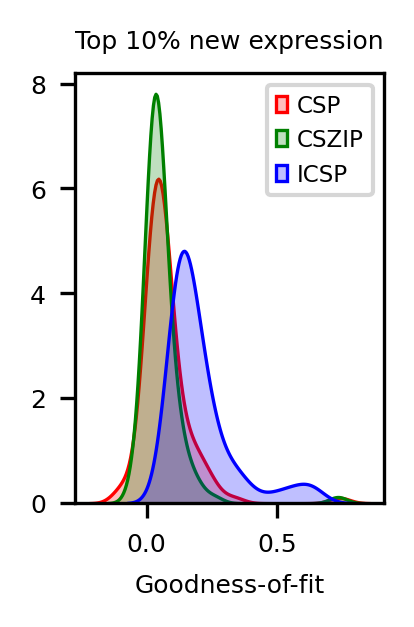

In [21]:
top_rate = 0.1
new = np.mean(sub_adata.layers['M_n'].A, axis=0)  # np.loadtxt('new.csv')
top_number = int(len(new)*top_rate)
arg_index_high_exp = np.argsort(-new)
index_high_exp = arg_index_high_exp[range(top_number)]
index_r2_high_CSP = np.intersect1d(index_high_exp, index_CSP_r2_over_n1)
index_r2_high_CSZIP = np.intersect1d(index_high_exp, index_CSZIP_r2_over_n1)
index_r2_high_ICSP = np.intersect1d(index_high_exp, index_ICSP_r2_over_n1)
fig = plt.figure(7, figsize=figsize_new, dpi=dpi)
ax = fig.add_subplot(111)
sns.kdeplot(CSP_gamma_r2[index_r2_high_CSP], shade=True, ax=ax, color='red', label='CSP', linewidth=0.8)
sns.kdeplot(CSZIP_gamma_r2[index_r2_high_CSZIP], shade=True, ax=ax, color='g', label='CSZIP', linewidth=0.8)
sns.kdeplot(ICSP_gamma_r2[index_r2_high_ICSP], shade=True, ax=ax, color='b', label='ICSP', linewidth=0.8)
plt.grid(False)
plt.title('Top 10% new expression')
plt.xlabel('Goodness-of-fit')
plt.ylabel('')
plt.legend()
# plt.savefig('./figures/figure2/Comp/gof_top10.pdf', dpi=dpi, bbox_inches="tight")
plt.show()

## Enrichment analysis results based on parameter values

Once we have inferred all the parameters using the method described above, we can perform gene enrichment analysis based on the size of the parameters. We performed enrichment analyses for the top 50% and bottom 50% of parameter values ($\alpha, \gamma_t, \beta$ and $p_{off}$) in the well-fitted genes(top 40% of goodness-of-fit).

Import **dotplot** function in **gseapy** package to plot enrichment analysis results and change plotting parameters

In [22]:
from gseapy.plot import barplot, dotplot
sc.set_figure_params(scanpy=True, fontsize=16)

Set the proportion of well-fitted and enriched:

In [23]:
fit_well_ratio = 0.4
enrichment_ratio = 0.5
gene_list = sub_adata_without_spliced.var.index.tolist()

Function that performs a specified enrichment analysis according to the selected parameters and plots the results:

In [24]:
def enrich(param, gof, gene_list, param_name, method_name, top_or_bottom, 
           fit_well_ratio, enrichment_ratio, ofname):
    total_number = len(gene_list)
    fit_well_number = int(fit_well_ratio * total_number)
    final_number = int(fit_well_number * enrichment_ratio)
    
    index_fit_well = np.argsort(-gof)[range(fit_well_number)]
    gene_list_fit_well = [gene_list[index_fit_well[i]] for i in range(len(index_fit_well))]
    param_fit_well = param[index_fit_well]

    if top_or_bottom == 'top':
        index = np.argsort(-param_fit_well)[range(final_number)]
    else:
        index = np.argsort(param_fit_well)[range(final_number)]

    final_gene_list = [gene_list_fit_well[index[i]] for i in range(len(index))]
    enr = dyn.ext.enrichr(final_gene_list, organism='human',
                          gene_sets='GO_Biological_Process_2018', cutoff=0.05)
    if param_name == 'prob_off':
        title = f'genes with {top_or_bottom} {100*enrichment_ratio}%'+ ' $p_{off}$ ' + f'(method {method_name})' 
    else:
        title = f'genes with {top_or_bottom} {100*enrichment_ratio}% $\\{param_name}$ (method {method_name})'
    dotplot(enr.res2d, title=title, cmap='viridis_r', cutoff=0.1, figsize=(4, 6), ofname=ofname, show_ring=True)

### Enrichment analysis of genes with high parameter values

Genes based on the **top** 50% of $\boldsymbol{\alpha}$ calculated by the **CSP** method:

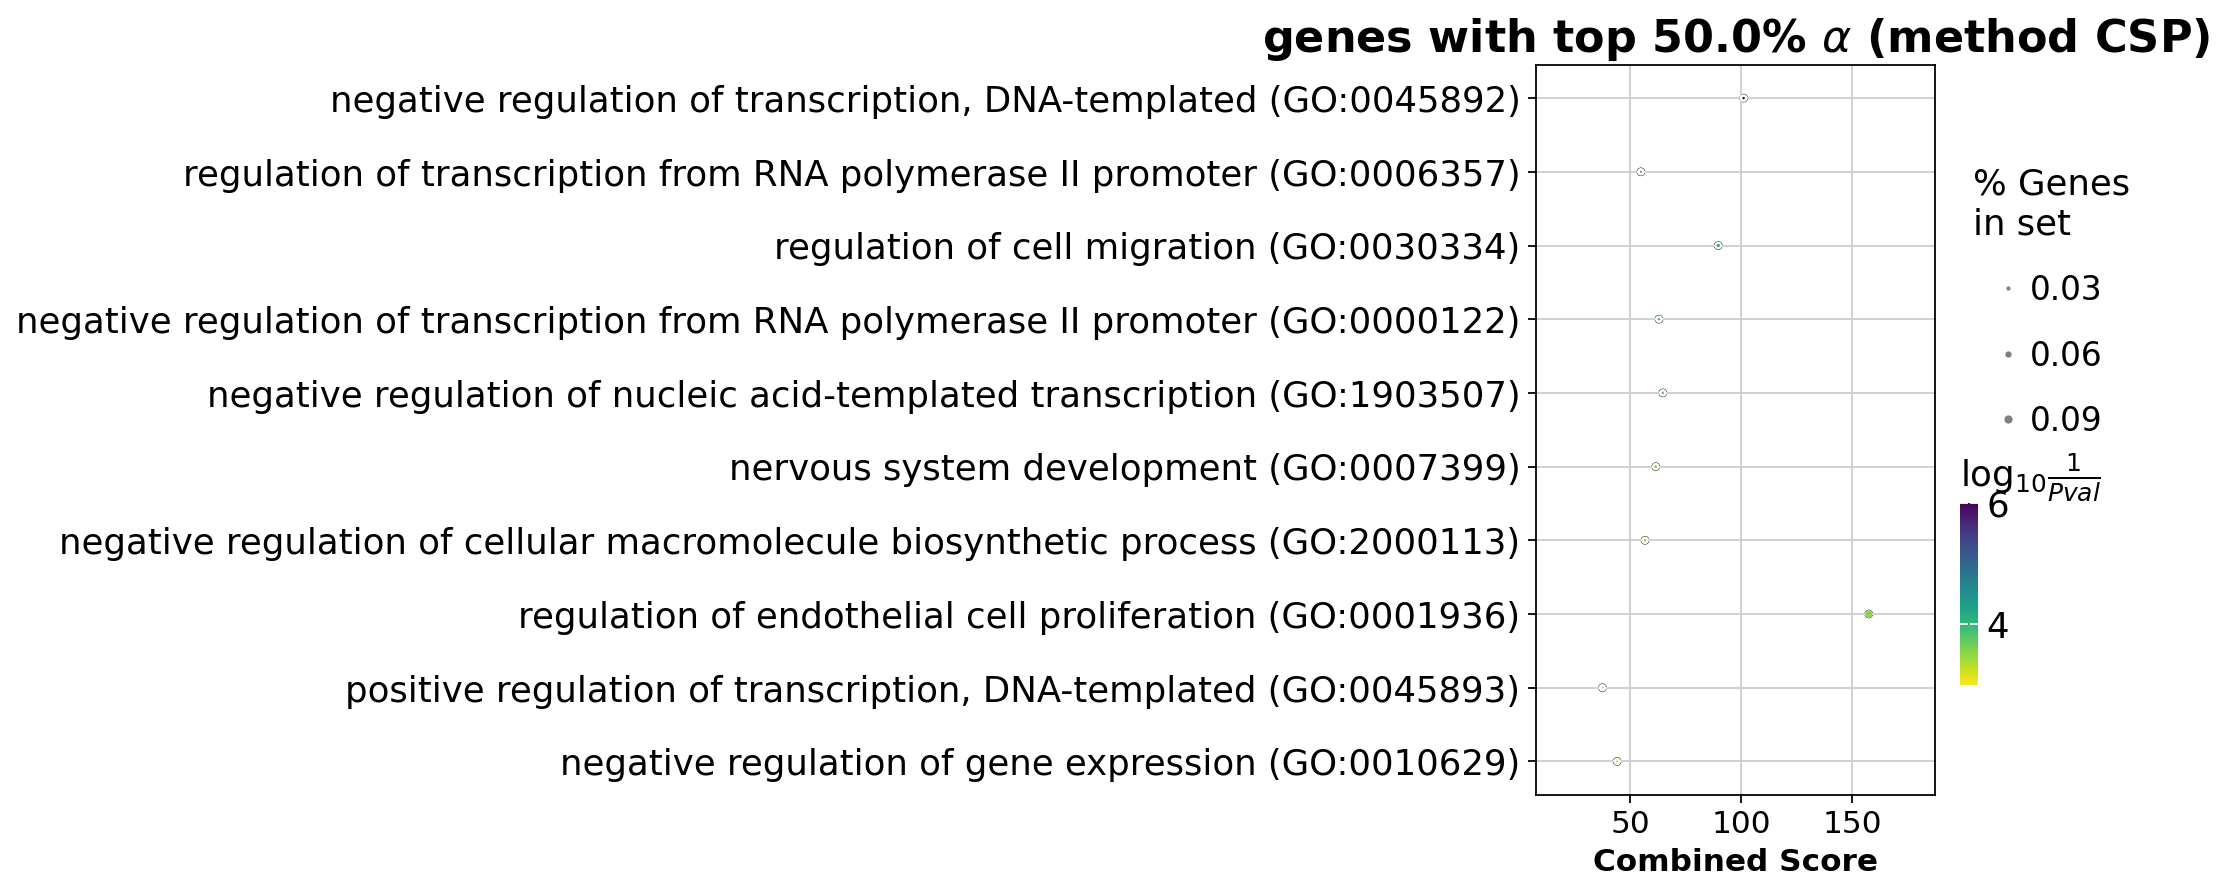

In [25]:
param_name = 'alpha'
method_name = 'CSP'
top_or_bottom = 'top'
# ofname = f'./Figures/dataset1/enrichment/enrichr/{method_name}/{param_name}_{top_or_bottom}.pdf'
ofname = None
enrich(CSP_alpha, CSP_gamma_r2, gene_list, param_name, method_name, top_or_bottom, 
           fit_well_ratio, enrichment_ratio, ofname)

Genes based on the **top** 50% of $\boldsymbol{\gamma_t}$ calculated by the **CSP** method:

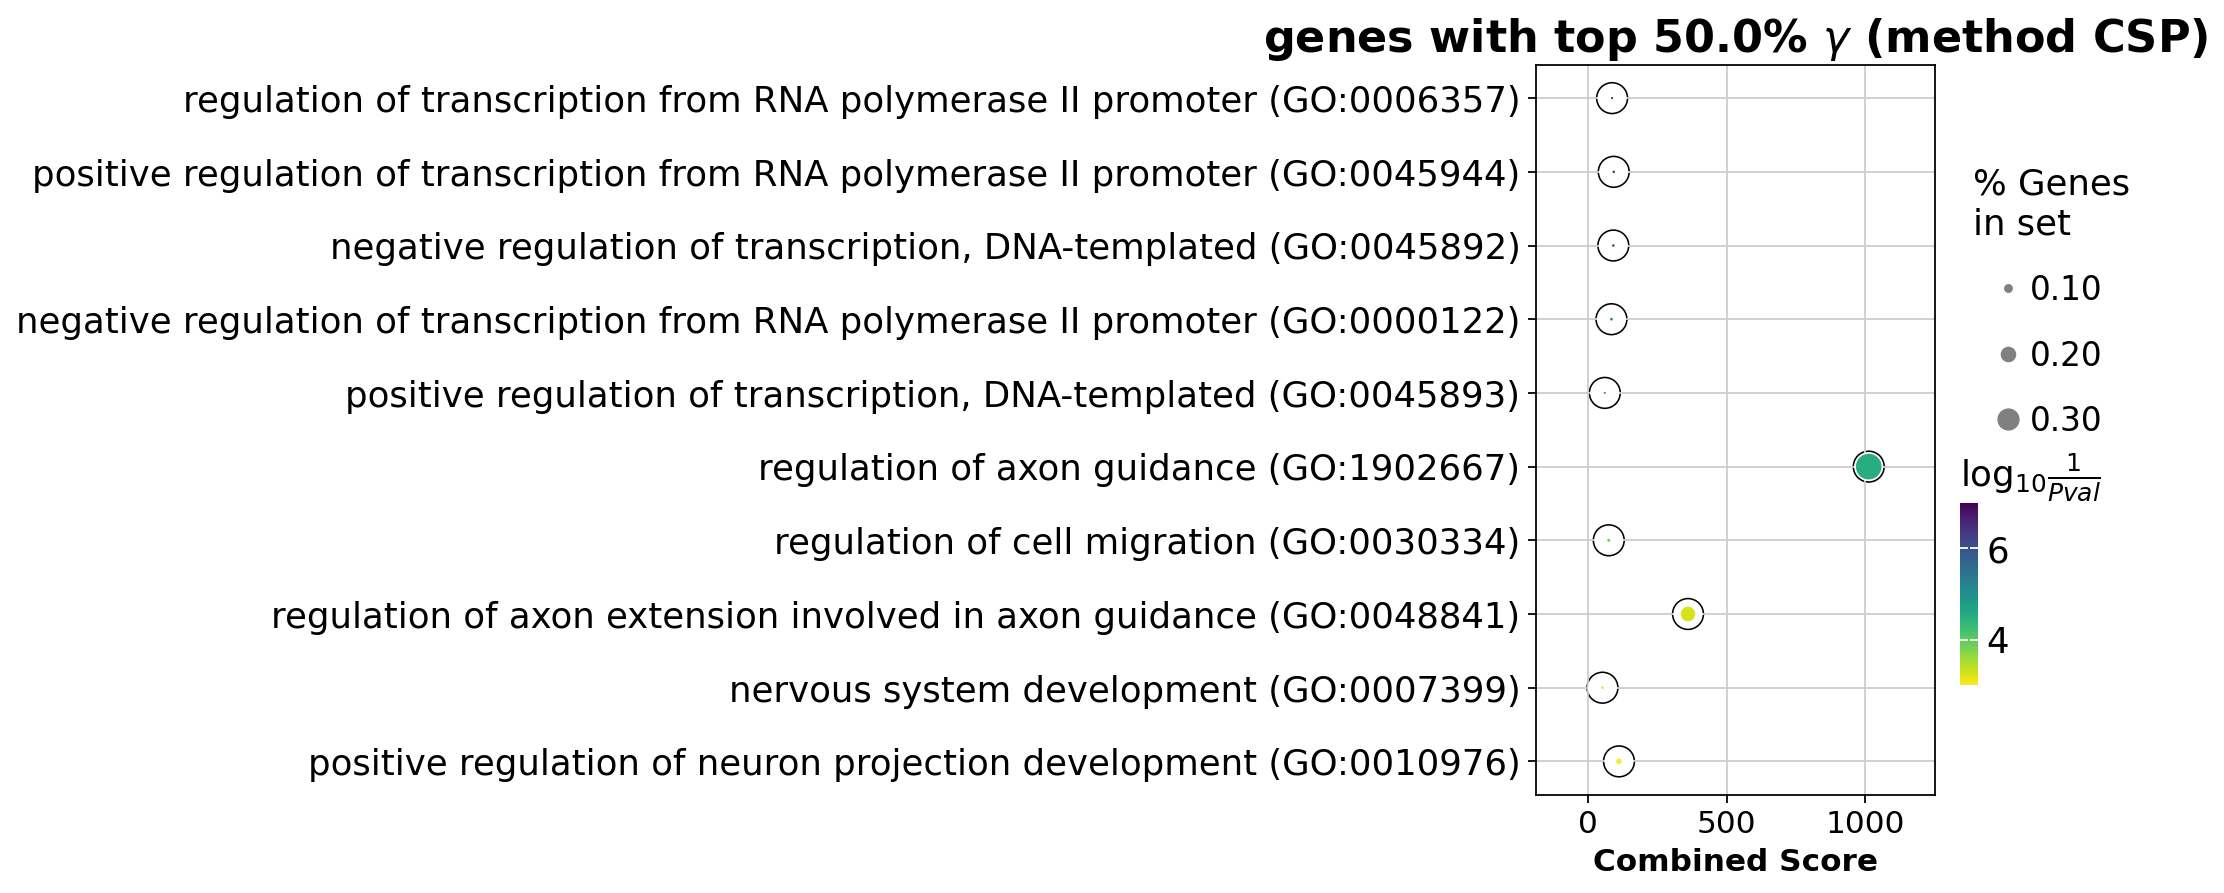

In [26]:
param_name = 'gamma'
method_name = 'CSP'
top_or_bottom = 'top'
# ofname = f'./Figures/dataset1/enrichment/enrichr/{method_name}/{param_name}_{top_or_bottom}.pdf'
ofname = None
enrich(CSP_gamma, CSP_gamma_r2, gene_list, param_name, method_name, top_or_bottom, 
           fit_well_ratio, enrichment_ratio, ofname)

Genes based on the **top** 50% of $\boldsymbol{\beta}$ calculated by the **ICSP** method:

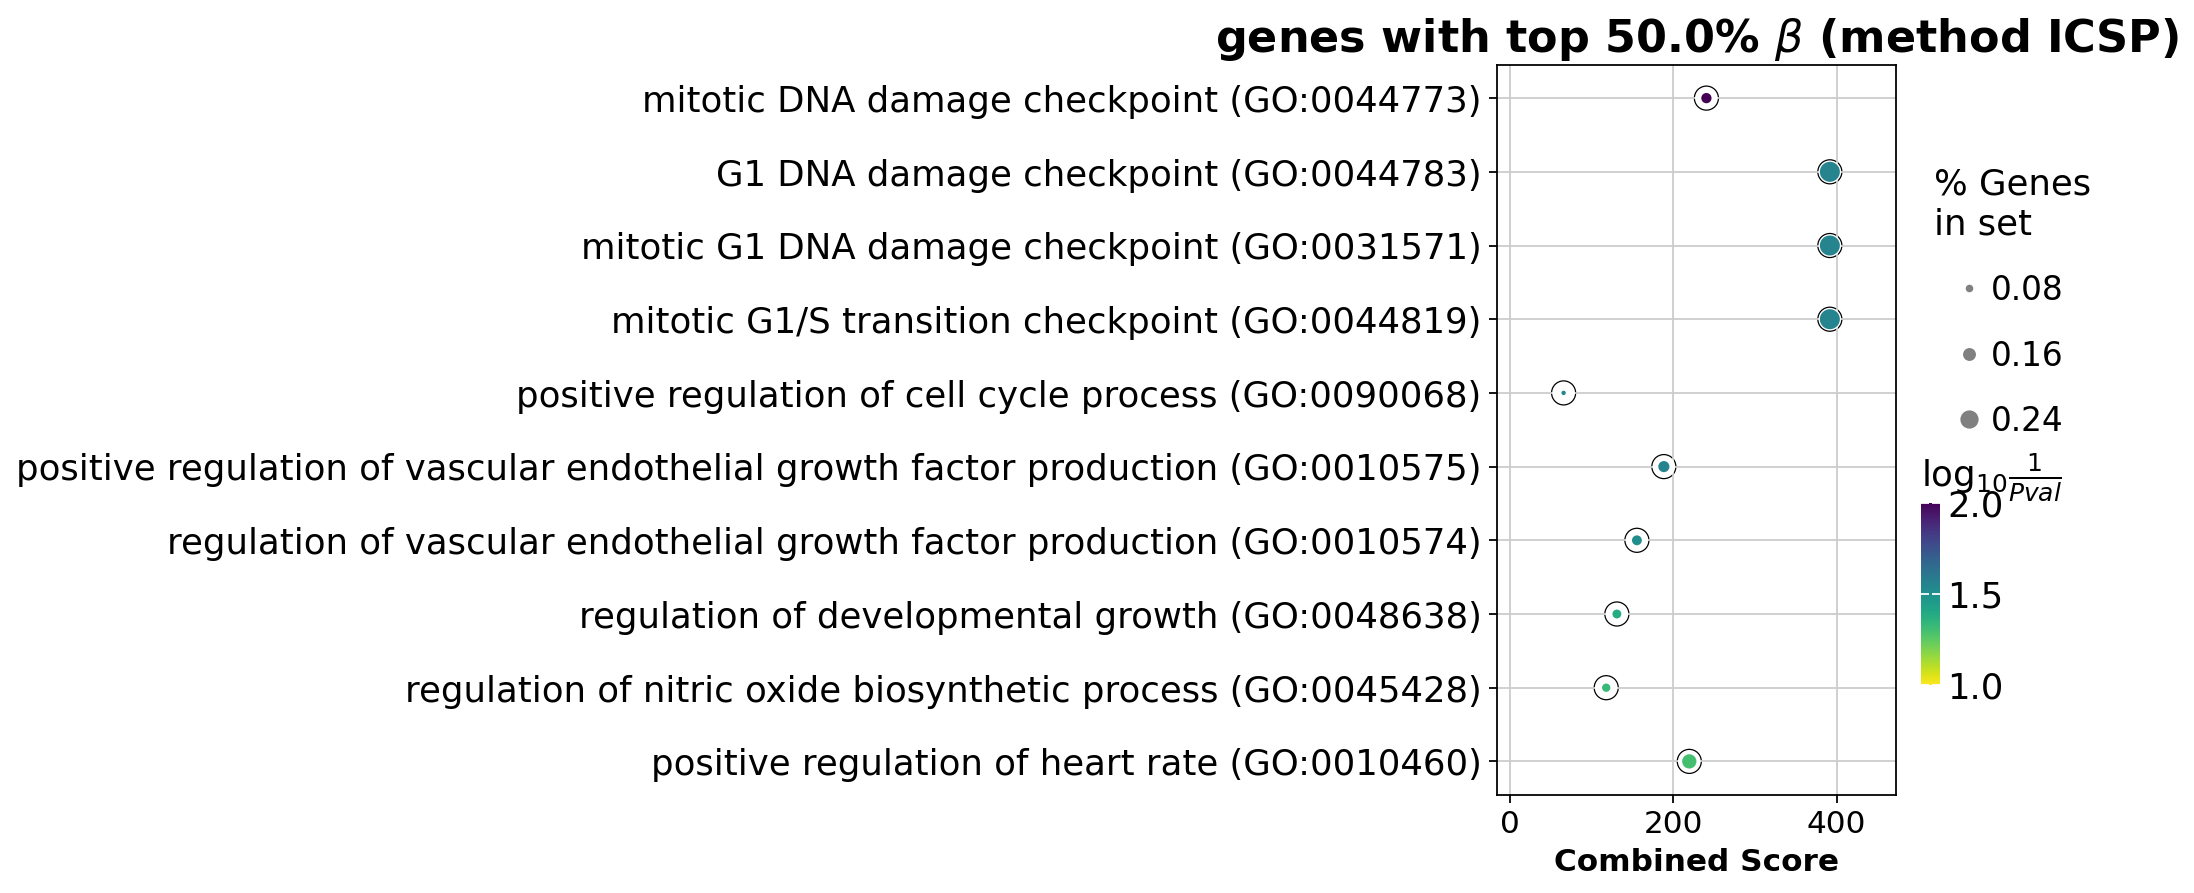

In [27]:
param_name = 'beta'
method_name = 'ICSP'
top_or_bottom = 'top'
# ofname = f'./Figures/dataset1/enrichment/enrichr/{method_name}/{param_name}_{top_or_bottom}.pdf'
ofname = None
enrich(ICSP_beta, ICSP_gamma_r2, gene_list, param_name, method_name, top_or_bottom, 
           fit_well_ratio, enrichment_ratio, ofname)

Genes based on the **top** 50% of $\boldsymbol{p_{off}}$ calculated by the **CSZIP** method:

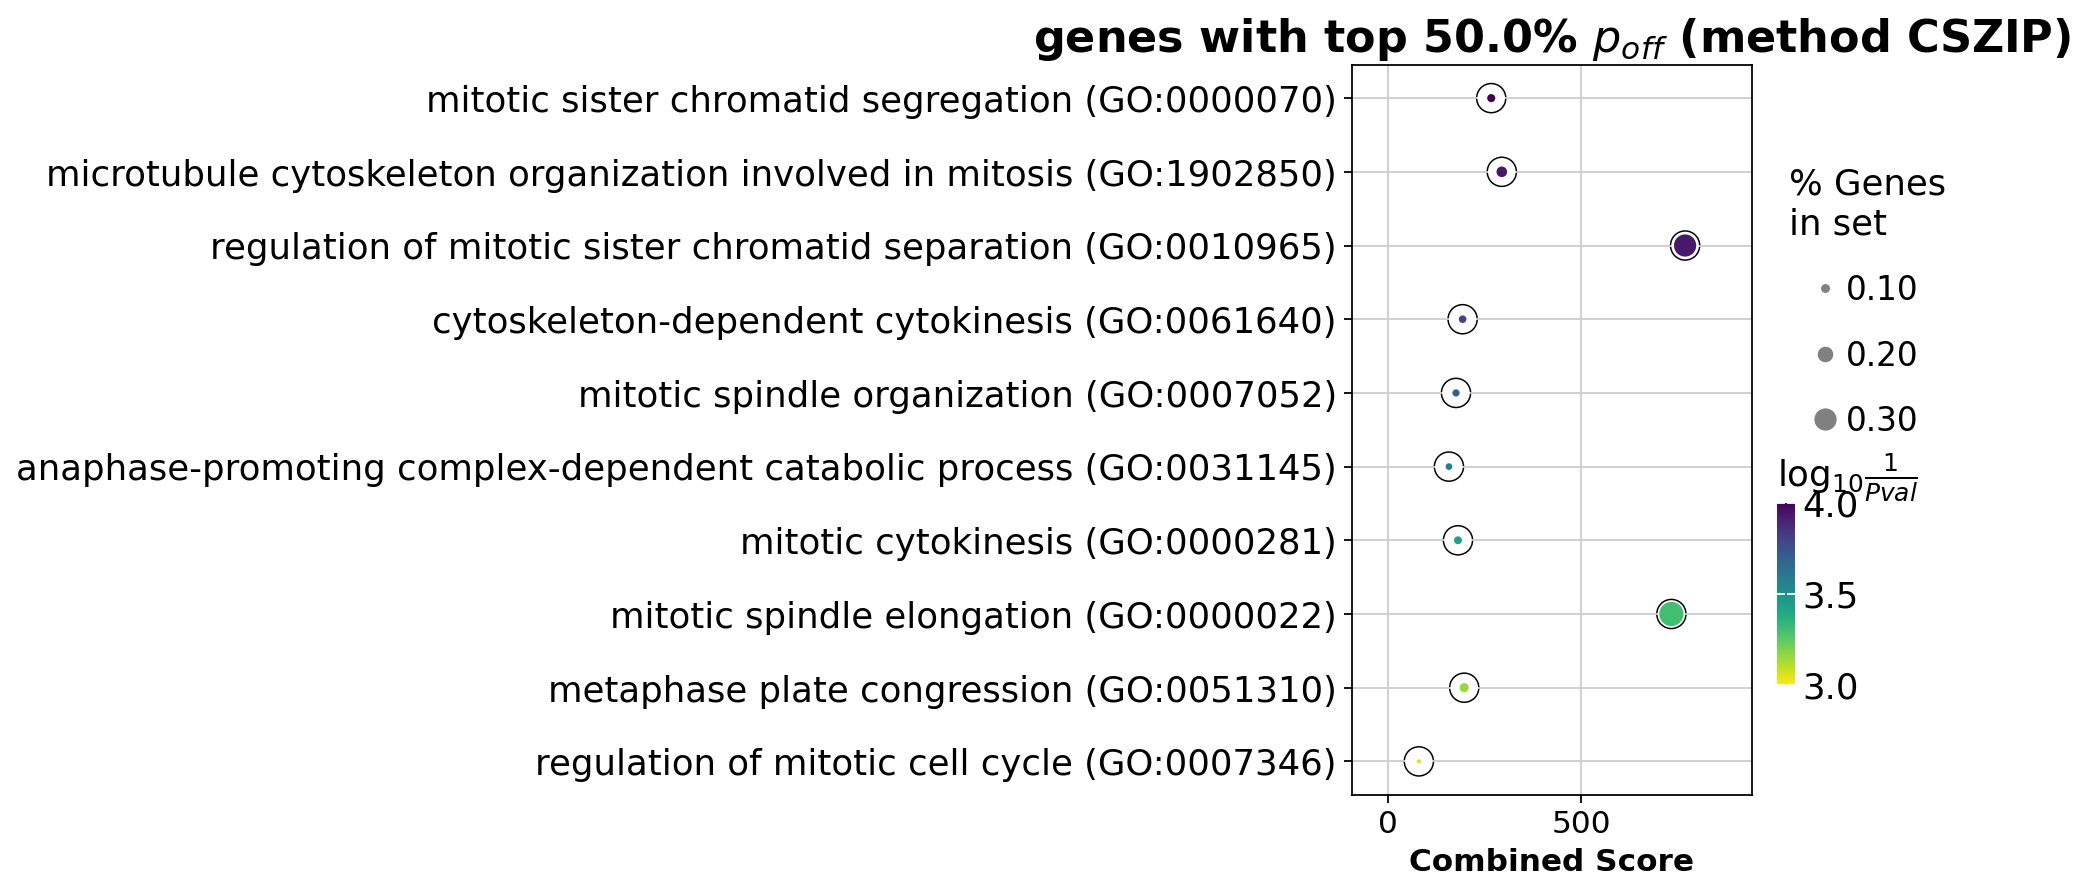

In [28]:
param_name = 'prob_off'
method_name = 'CSZIP'
top_or_bottom = 'top'
# ofname = f'./Figures/dataset1/enrichment/enrichr/{method_name}/{param_name}_{top_or_bottom}.pdf'
ofname = None
enrich(CSZIP_prob_off, CSZIP_gamma_r2, gene_list, param_name, method_name, top_or_bottom, 
           fit_well_ratio, enrichment_ratio, ofname)

### Enrichment analysis of genes with low parameter values

Genes based on the **bottom** 50% of $\boldsymbol{\alpha}$ calculated by the **CSP** method:

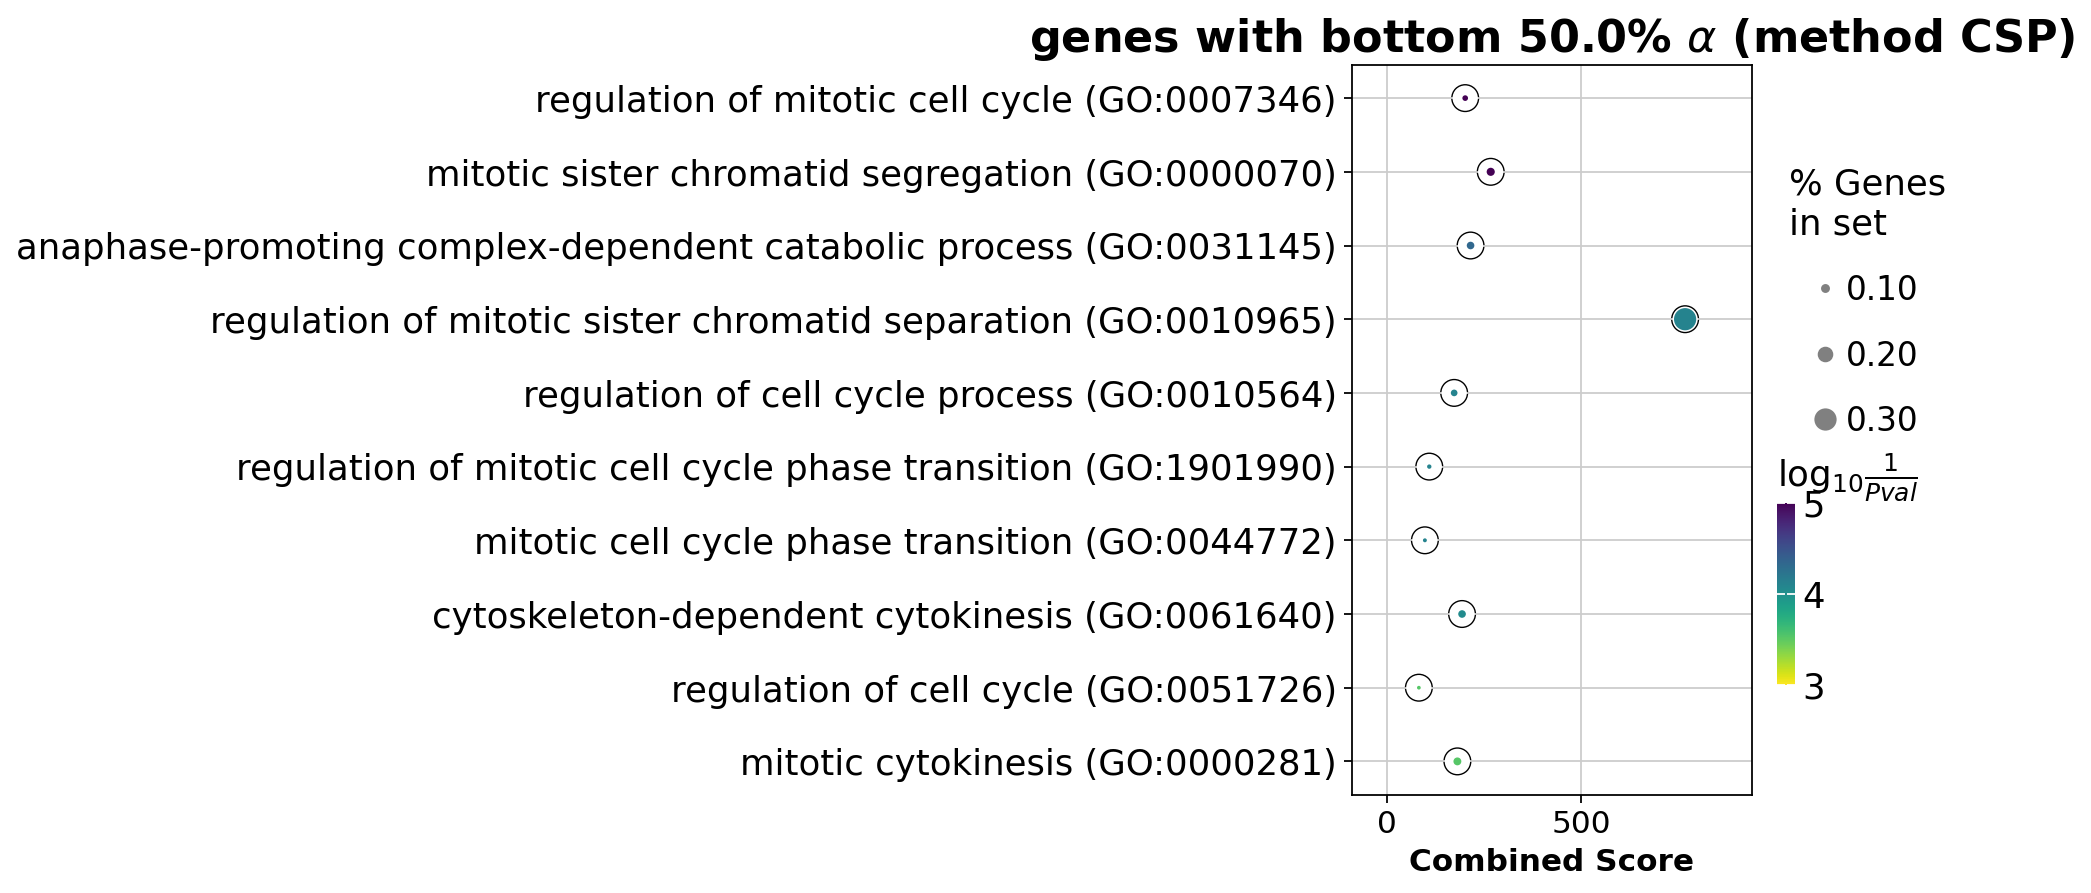

In [29]:
param_name = 'alpha'
method_name = 'CSP'
top_or_bottom = 'bottom'
# ofname = f'./Figures/dataset1/enrichment/enrichr/{method_name}/{param_name}_{top_or_bottom}.pdf'
ofname = None
enrich(CSP_alpha, CSP_gamma_r2, gene_list, param_name, method_name, top_or_bottom, 
           fit_well_ratio, enrichment_ratio, ofname)

Genes based on the **bottom** 50% of $\boldsymbol{\gamma_t}$ calculated by the **CSP** method:

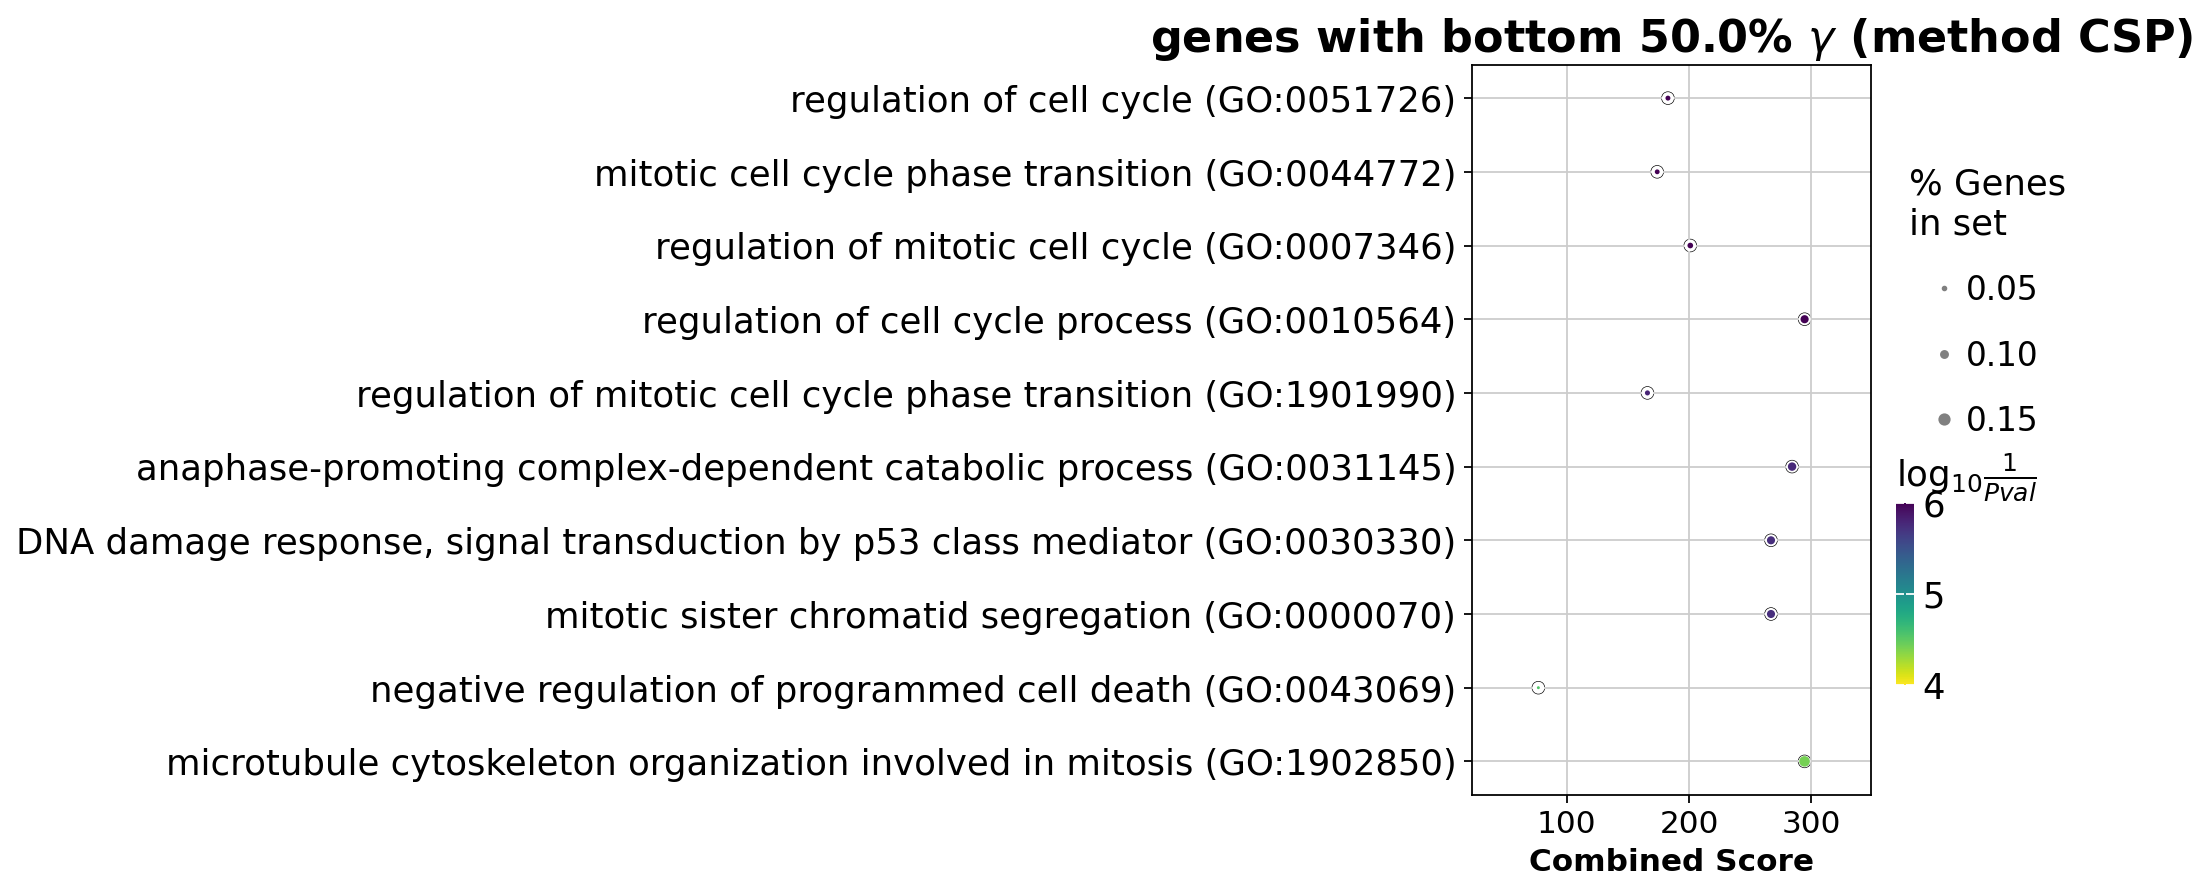

In [30]:
param_name = 'gamma'
method_name = 'CSP'
top_or_bottom = 'bottom'
# ofname = f'./Figures/dataset1/enrichment/enrichr/{method_name}/{param_name}_{top_or_bottom}.pdf'
ofname = None
enrich(CSP_gamma, CSP_gamma_r2, gene_list, param_name, method_name, top_or_bottom, 
           fit_well_ratio, enrichment_ratio, ofname)

Genes based on the **bottom** 50% of $\boldsymbol{\beta}$ calculated by the **ICSP** method:

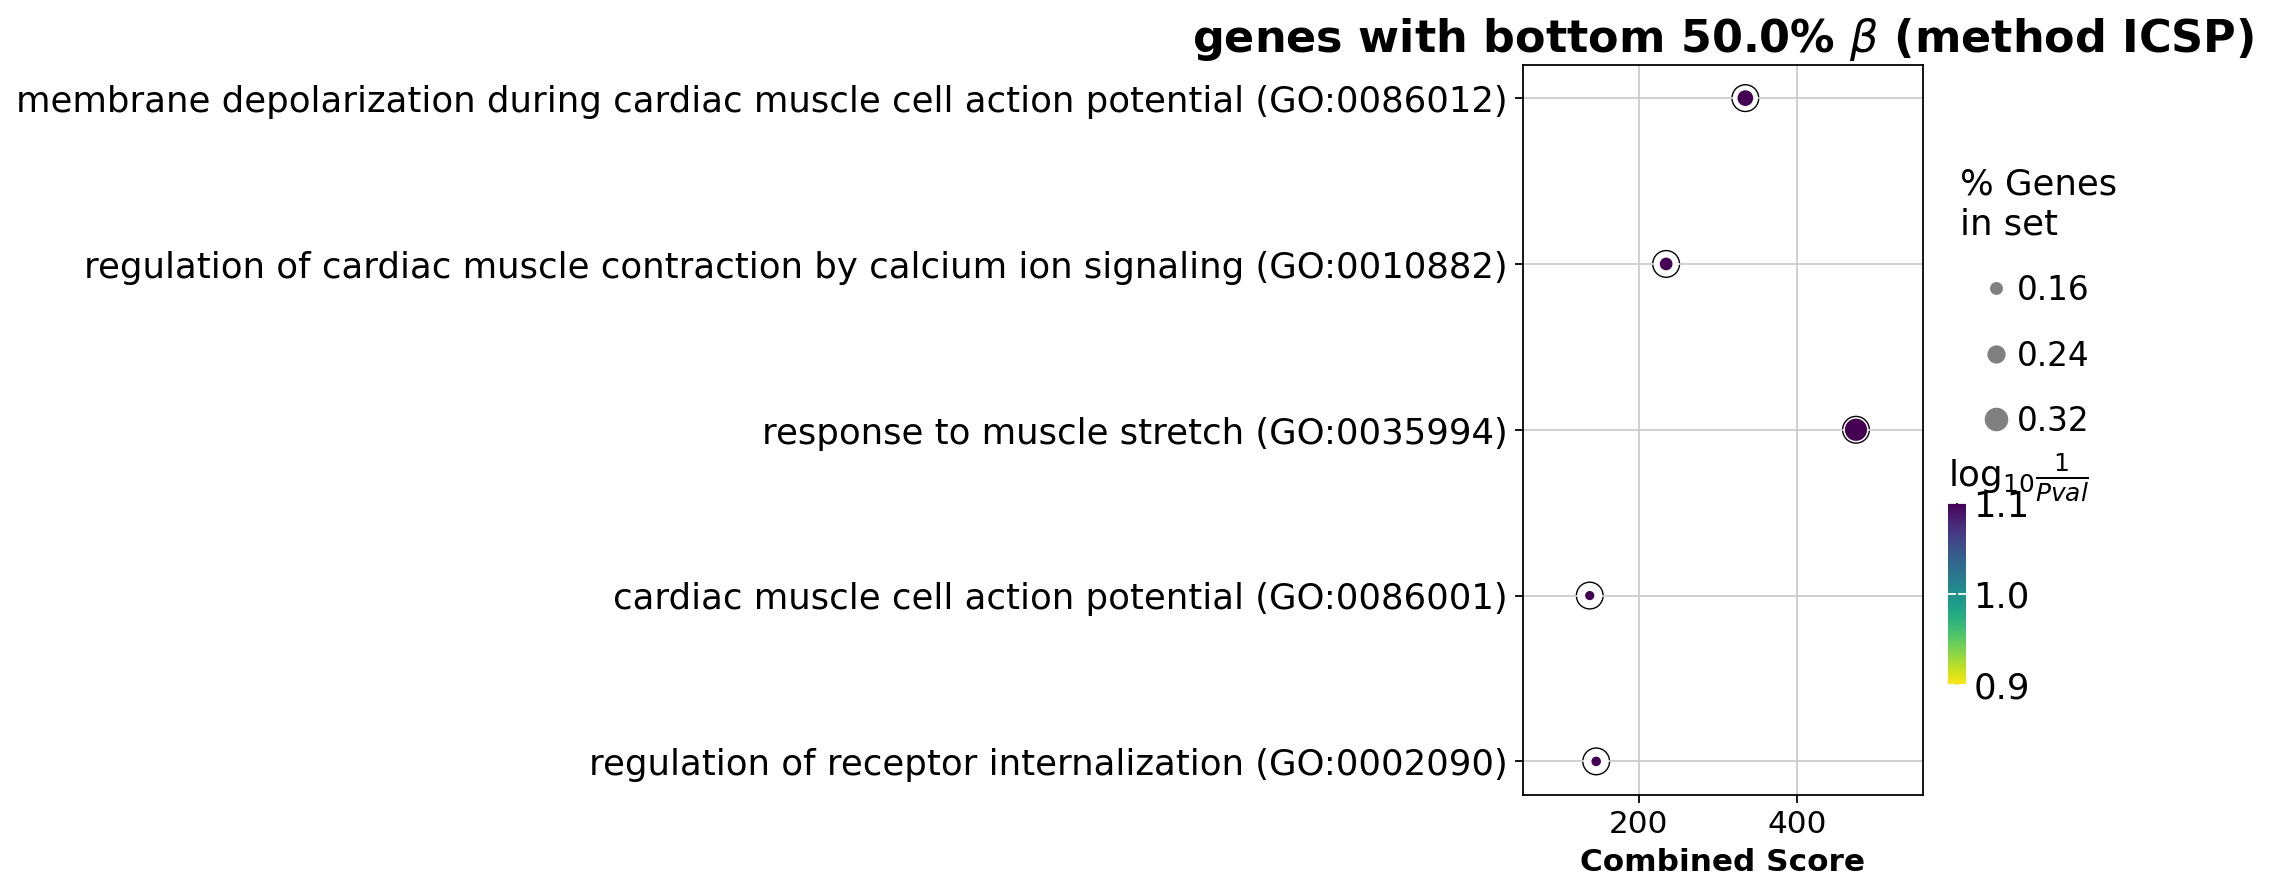

In [31]:
param_name = 'beta'
method_name = 'ICSP'
top_or_bottom = 'bottom'
# ofname = f'./Figures/dataset1/enrichment/enrichr/{method_name}/{param_name}_{top_or_bottom}.pdf'
ofname = None
enrich(ICSP_beta, ICSP_gamma_r2, gene_list, param_name, method_name, top_or_bottom, 
           fit_well_ratio, enrichment_ratio, ofname)

Genes based on the **bottom** 50% of $\boldsymbol{p_{off}}$ calculated by the **CSZIP** method:

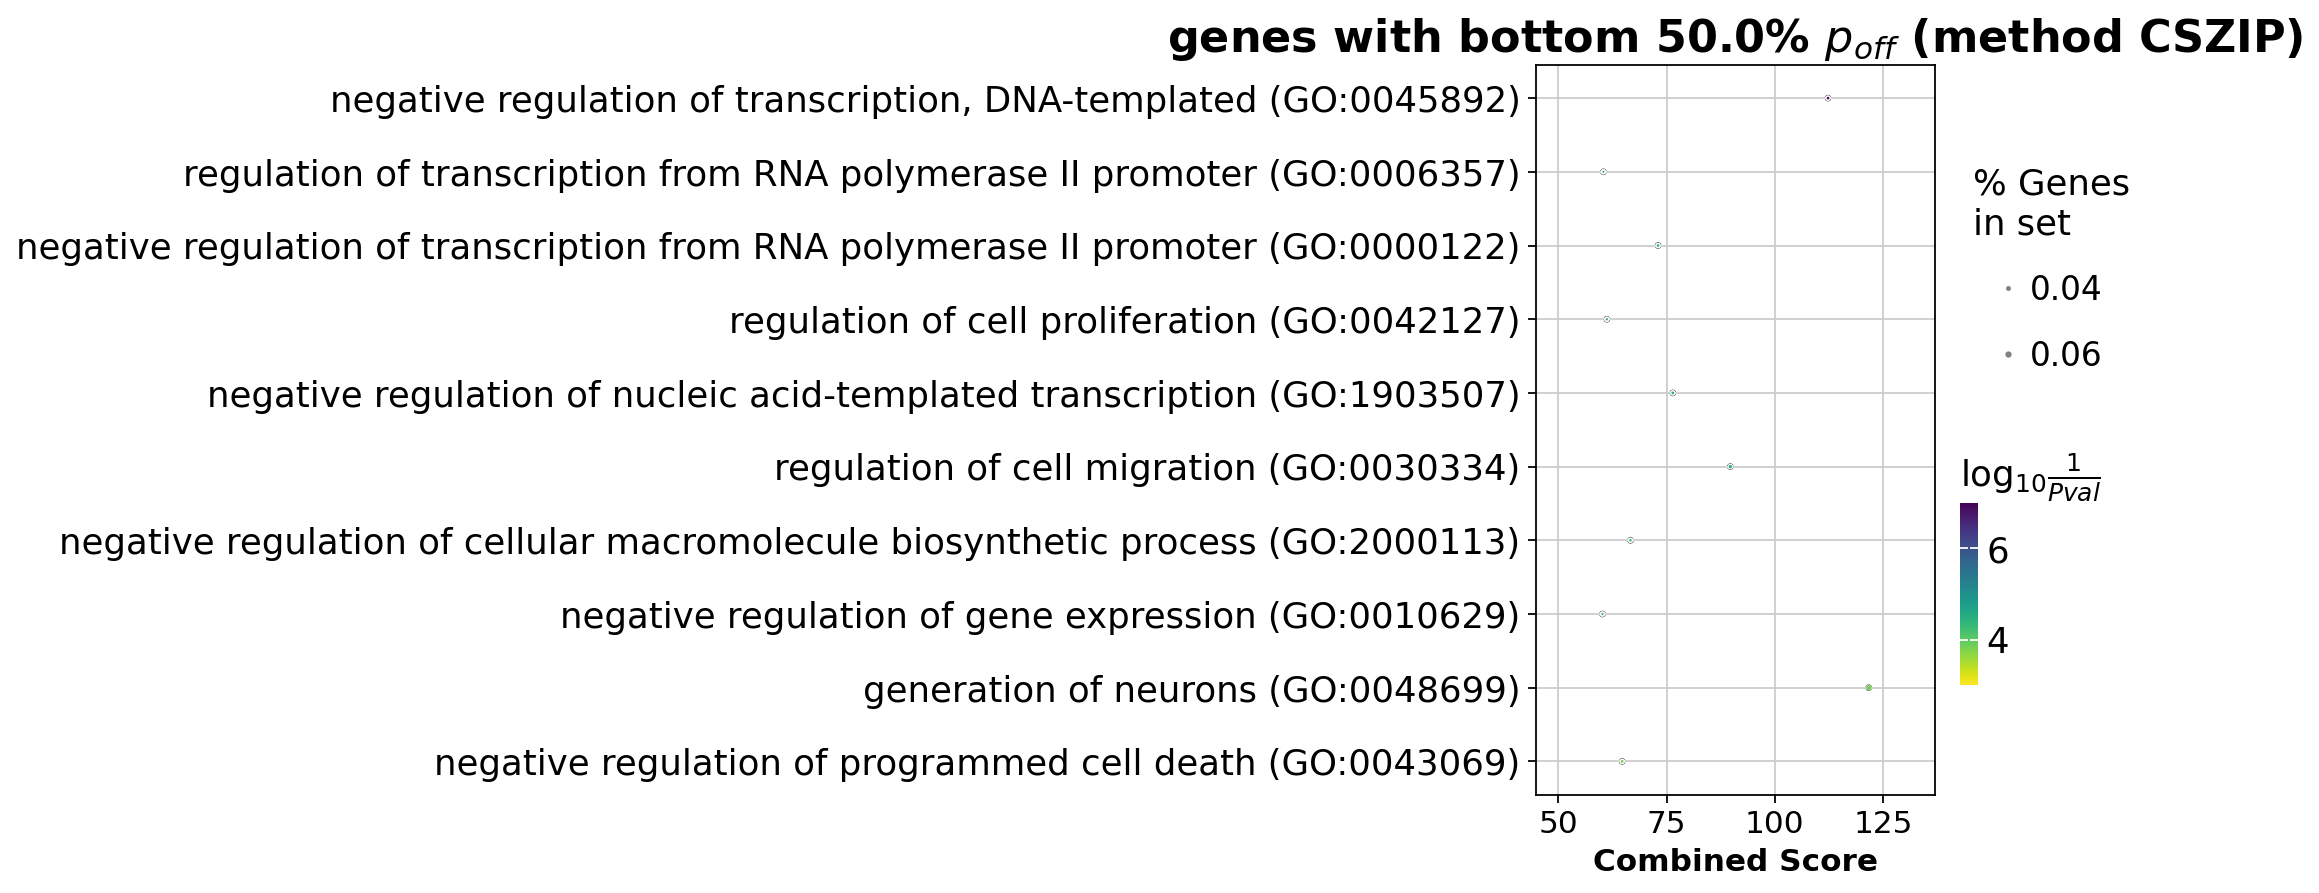

In [32]:
param_name = 'prob_off'
method_name = 'CSZIP'
top_or_bottom = 'bottom'
# ofname = f'./Figures/dataset1/enrichment/enrichr/{method_name}/{param_name}_{top_or_bottom}.pdf'
ofname = None
enrich(CSZIP_prob_off, CSZIP_gamma_r2, gene_list, param_name, method_name, top_or_bottom, 
           fit_well_ratio, enrichment_ratio, ofname)